In [1]:
# Import libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,year,month,source,fuel_type,emissions_tons
0,1987,1,transport,oil,1588.61
1,1987,2,transport,oil,1428.29
2,1987,3,transport,oil,1581.16
3,1987,4,transport,oil,1557.40
4,1987,5,transport,oil,1513.35


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            2352 non-null   int64  
 1   month           2352 non-null   int64  
 2   source          2352 non-null   object 
 3   fuel_type       2352 non-null   object 
 4   emissions_tons  2352 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 92.0+ KB


## DownCasting

In [4]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [5]:
train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   year            2352 non-null   int16   
 1   month           2352 non-null   int8    
 2   source          2352 non-null   category
 3   fuel_type       2352 non-null   category
 4   emissions_tons  2352 non-null   float16 
dtypes: category(2), float16(1), int16(1), int8(1)
memory usage: 16.5 KB


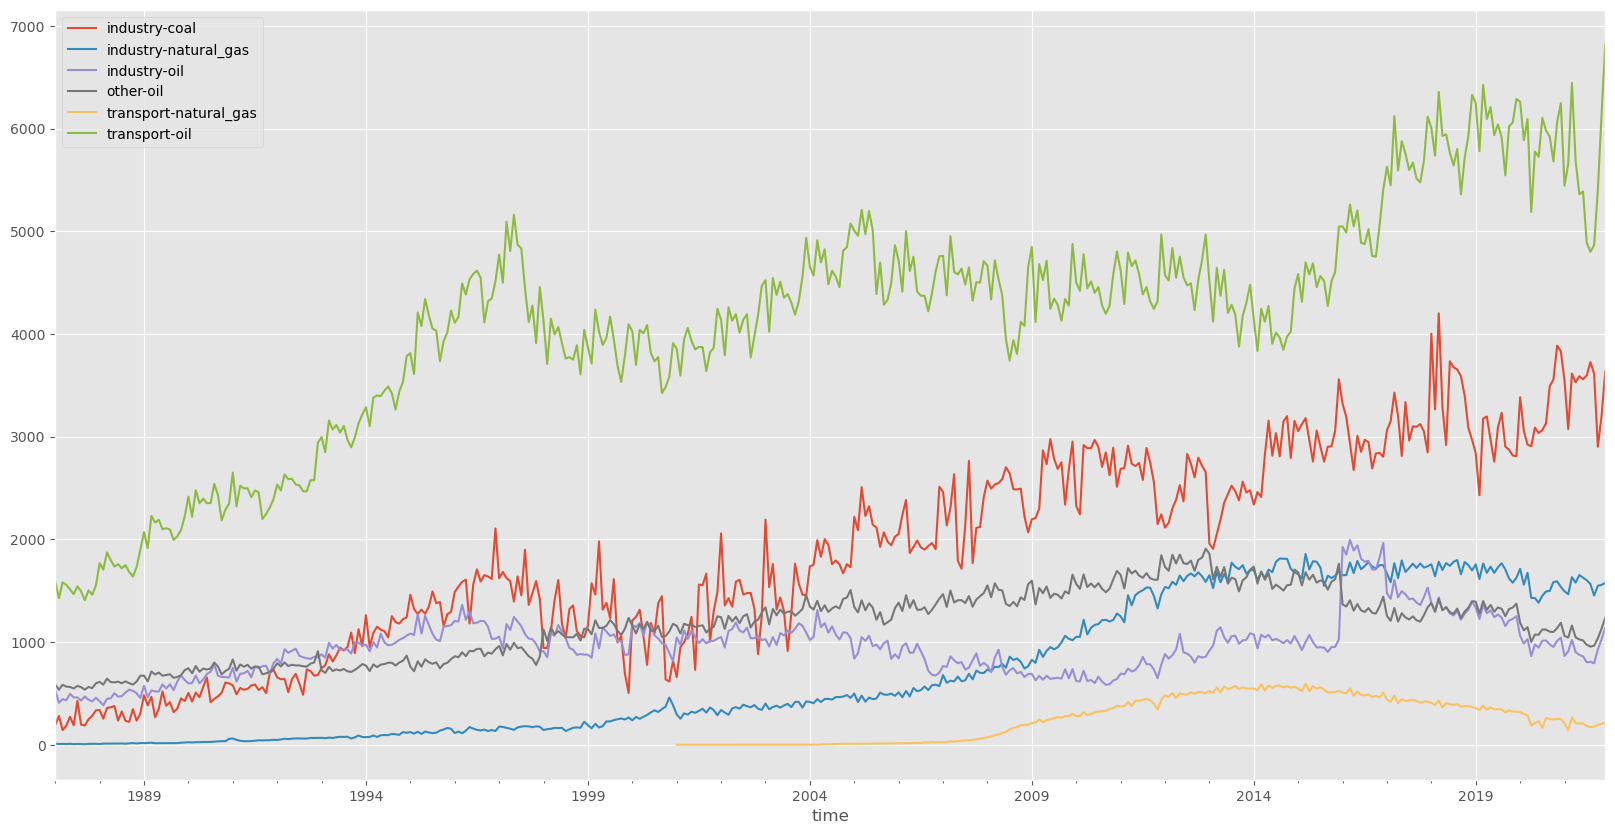

In [6]:
# obtain datetime from year column
train["time"] = train.apply(lambda row : pd.to_datetime(str(row["year"]) + " " + str(row["month"])), axis = 1)
train["source_fueltype"] = train[["source", "fuel_type"]].apply("-".join, axis=1)
train.set_index('time', inplace=True)
train.groupby('source_fueltype')["emissions_tons"].plot(legend=True)
plt.show()


## Modeling

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from jcopml.tuning.space import Integer, Real
from jcopml.feature_importance import mean_score_decrease

In [7]:
train = pd.read_csv("data/train.csv")

In [9]:
X = train.drop("emissions_tons", axis=1)
y = train.emissions_tons

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [10]:
params = {
    "algo__n_estimators": Integer(low=100, high=1000),
    "algo__learning_rate": Integer(low=0.01, high=1),
    "algo__subsample": Real(low=0.2, high=0.8),
    "algo__colsample_bytree": Real(low=0.1, high=1),
    "algo__max_depth": Integer(low=1, high=16),
    "algo__num_leaves": Integer(low=1, high=50),
    "algo__min_child_weight": Integer(low=100, high=400)
}

In [11]:
cat_pipe = Pipeline([("encode", OneHotEncoder())])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,1]),
    ("categoric", cat_pipe, [2,3])
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", LGBMRegressor())
])

model = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               [0,
                                                                                1]),
                                                                              ('categoric',
                                                                               Pipeline(steps=[('encode',
                                                                                                OneHotEncoder())]),
                                                                               [2,
                                                                                3])])),
                                             ('algo', LGBMRegressor())]),
                   n_jobs=-1,
                   param_distributions={'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
                                        'algo__learning_rate': Integer(low=0.01, high=1),
                                        'algo__max_depth': Integer(low=1, high=16),
                                        'algo__min_child_weight': Integer(low=100, high=400),
                                        'algo__n_estimators': Integer(low=100, high=1000),
                                        'algo__num_leaves': Integer(low=1, high=50),
                                        'algo__subsample': Real(low=0.2, high=0.8, prior='uniform')},
                   verbose=1)

In [12]:
model.best_params_

{'algo__colsample_bytree': 0.6439773703724787,
 'algo__learning_rate': 1,
 'algo__max_depth': 11,
 'algo__min_child_weight': 105,
 'algo__n_estimators': 306,
 'algo__num_leaves': 3,
 'algo__subsample': 0.48938221531668386}

## Evaluation Metric

In [16]:
train_pred = model.predict(X_train)
train_mse = mean_squared_error(train_pred, y_train)
print(f"root mean squared error train: {np.sqrt(train_mse)}")

val_pred = model.predict(X_val)
val_mse = mean_squared_error(val_pred, y_val)
print(f"root mean squared error validasi: {np.sqrt(val_mse)}")

root mean squared error train: 223.2271388542709
root mean squared error validasi: 244.05174332522182


## Test data

In [17]:
test = pd.read_csv("data/test.csv")
test.head()

,year,month,source,fuel_type
0,2022,1,transport,oil
1,2022,2,transport,oil
2,2022,3,transport,oil
3,2022,4,transport,oil
4,2022,5,transport,oil


In [18]:
pred = model.predict(test)
test['emissions_tons'] = pred
test.head()

,year,month,source,fuel_type,emissions_tons
0,2022,1,transport,oil,5322.203767
1,2022,2,transport,oil,5237.024484
2,2022,3,transport,oil,5454.828307
3,2022,4,transport,oil,5328.271304
4,2022,5,transport,oil,5353.102236


In [19]:
column_order = ['emissions_tons', 'year', 'month', 'source', 'fuel_type']
test = test.reindex(columns=column_order)

test.to_csv("data/submission.csv", index=False)

In [20]:
pd.read_csv("data/submission.csv")

,emissions_tons,year,month,source,fuel_type
0,5322.203767,2022,1,transport,oil
1,5237.024484,2022,2,transport,oil
2,5454.828307,2022,3,transport,oil
3,5328.271304,2022,4,transport,oil
4,5353.102236,2022,5,transport,oil
...,...,...,...,...,...
67,1376.477117,2022,8,industry,natural_gas
68,1335.647796,2022,9,industry,natural_gas
69,1332.026144,2022,10,industry,natural_gas
70,1324.250218,2022,11,industry,natural_gas


In [21]:
test.emissions_tons.sum()

154621.60035349533

estimated total CO2 emissions in Thailand in 2022 of 154621.600

In [22]:
test_copy = test.copy()

In [23]:
test_copy["source_fueltype"] = test_copy[["source", "fuel_type"]].apply("-".join, axis=1)
del test_copy["source"]
del test_copy["fuel_type"]

In [24]:
# Menghitung jumlah total kolom 'emissions_tons' dan rata-rata emisi pada setiap nilai unik di kolom 'source_fueltype'
total_emissions = test_copy['emissions_tons'].sum()
summary_df = test_copy.groupby('source_fueltype')['emissions_tons'].agg(['sum', 'mean'])

# Menampilkan hasil
print(summary_df)

                                sum         mean
source_fueltype                                 
industry-coal          37827.601297  3152.300108
industry-natural_gas   15901.692485  1325.141040
industry-oil           17153.098777  1429.424898
other-oil              13770.337985  1147.528165
transport-natural_gas   6337.911539   528.159295
transport-oil          63630.958269  5302.579856


In [25]:
def calculate_percentage(emissions_dict):
    total_emissions = sum(emissions_dict.values())
    percentages = {}
    for source_fueltype, emissions in emissions_dict.items():
        percentage = (emissions / total_emissions) * 100
        percentages[source_fueltype] = percentage
    return percentages

# Dictionary dengan sumbangan masing-masing sumber bahan bakar
emissions_dict = {
    'transport-oil': 63630.95,
    'industry-oil': 17153.09,
    'other-oil': 17153.09,
    'industry-coal': 37827.60,
    'transport-natural_gas': 6337.9,
    'industry-natural_gas': 15901.69
}

percentages = calculate_percentage(emissions_dict)

# Menampilkan hasil
print("Contribution percentage of each fuel source:")
for source_fueltype, percentage in percentages.items():
    print(f"{source_fueltype} : {np.round(percentage, 2)}%")

Contribution percentage of each fuel source:
transport-oil : 40.27%
industry-oil : 10.86%
other-oil : 10.86%
industry-coal : 23.94%
transport-natural_gas : 4.01%
industry-natural_gas : 10.06%


The total estimated emission in 2022 is 154621.600 while the estimate for transport_oil sources on average contributes (40.27%), industry_oil contributes (10.86%), other_oil (10.86%), industry_coal (23.94%), transport_natural_gas (4.01%) and industry_natural_gas on average contributes (10.06%).